# Imports

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import joblib

# Import functions from preprocessing and training modules
from preprocessing import process_unstructured_data_to_csv, get_labelled_csv, process_all_files
from feature_extract import create_model_dataset, load_dataset_with_features

# Import model training libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Preprocess raw data

Fourier transformation of the values from time domain --> frequency domain.

In [96]:
# Get current working directory
cwd = os.getcwd()

# Define data directory
data_dir = os.path.join(cwd, 'sample_data' + '\\' + 'raw_data')

print("Processing data from directory:", data_dir)

Processing data from directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\raw_data


In [97]:
# Delete all previously processed files to avoid conflicts
structured_dir = os.path.join(cwd, 'sample_data' + '\\' + 'structured')
processed_dir = os.path.join(cwd, 'sample_data' + '\\' + 'processed')
labelled_dir = os.path.join(cwd, 'sample_data' + '\\' + 'labelled')
model_data_dir = os.path.join(cwd, 'model_data')

shutil.rmtree(structured_dir, ignore_errors=True)
shutil.rmtree(processed_dir, ignore_errors=True)
shutil.rmtree(labelled_dir, ignore_errors=True)
shutil.rmtree(model_data_dir, ignore_errors=True)

In [98]:
# Get list of all files in the data_dir folder
file_names = os.listdir(data_dir)

shout_time_interval = 23 # milliseconds between data points
drill_time_interval = 23 # milliseconds between data points

for file_name in file_names:

    print(f"\nProcessing file: {file_name}")
    
    # Save processed CSV dataframe from the unstructured data file
    if 'shout' in file_name:
        time_interval = shout_time_interval
    elif 'drill' in file_name:
        time_interval = drill_time_interval
    process_unstructured_data_to_csv(data_dir + '\\' + file_name, time_interval)

    # Separate csv further into 'shout' and 'background'
    if 'shout' in file_name:
        get_labelled_csv(data_dir + '\\' + file_name.split('.')[0] + '.csv', type='shout', labelling_interval=5)

    elif 'drill' in file_name:
        get_labelled_csv(data_dir + '\\' + file_name.split('.')[0] + '.csv', type='drill', labelling_interval=5)


Processing file: drill11.json
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\drill11_structured.csv

Processing file: drill12.json
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\drill12_structured.csv

Processing file: drill13.json
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\drill13_structured.csv

Processing file: drill14.json
Directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data
CSV file saved as c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\structured\drill14_structured.csv

Processing file: drill15.json
Directory: c:\Users\hoxia

In [99]:
frame_size = 30  # Number of data points per frame, so that each data sample is 0.5-0.9 seconds long
overlap_percentage = 80 # Percentage of overlap between frames

# For each file, we will create frames and process them with fourier transform, saving results to new CSVs
process_all_files(
    input_base_dir=cwd + '\\' + 'sample_data' + '\\' + 'labelled',  # Contains background/ and shout/ folders with CSVs
    output_base_dir=cwd + '\\' +'sample_data' + '\\' + 'processed',    # Output directory for processed CSVs
    frame_size=frame_size,
    overlap_percent=overlap_percentage
)

Processing background/drill11_2.csv...
Processed 31 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill11_4.csv...
Processed 31 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill12_2.csv...
Processed 31 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill12_4.csv...
Processed 31 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spectrograms/background
Processing background/drill13_2.csv...
Processed 31 frames with 80% overlap
Spectrogram directory: c:\Users\hoxia\Documents\Cloud\NoiseWatch\noise_prediction\sample_data\processed/spec

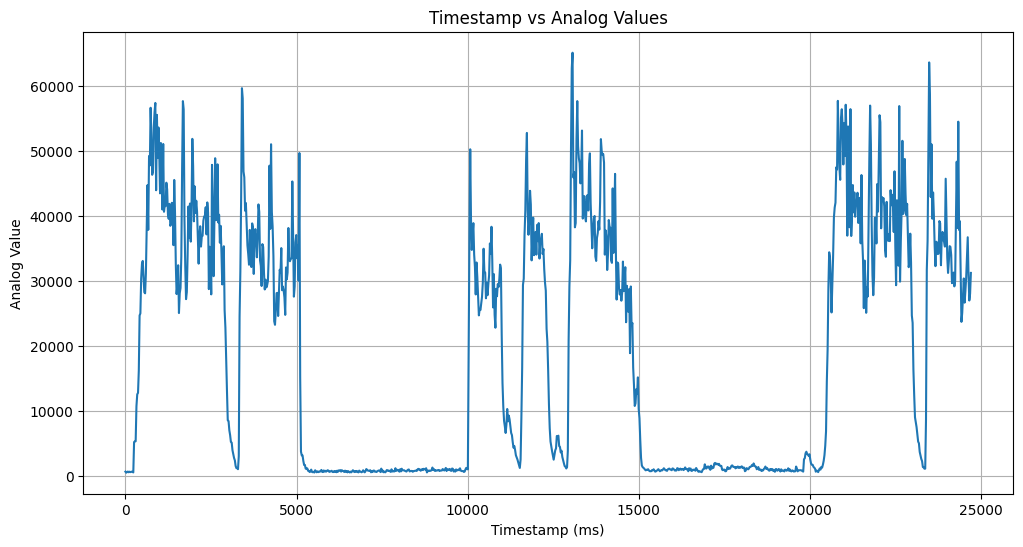

In [100]:
# An example of one set of analog values of raw data
sample_structured_file = cwd + '\\' + 'sample_data' + '\\' + 'structured' + '\\' + 'shout11_structured.csv'

# plot timestamp vs analog values
df = pd.read_csv(sample_structured_file)
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['analog_value'])
plt.title('Timestamp vs Analog Values')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Analog Value')
plt.grid()

# Prepare dataset and train

In [101]:
create_model_dataset(
    freq_domain_dir=cwd + '\\' + 'sample_data' + '\\' + 'processed',
    output_dir=cwd + '\\' + 'model_data'
)


background: 527 train, 62 val, 31 test
shout: 398 train, 47 val, 24 test
drill: 399 train, 47 val, 24 test


In [117]:
X_train, y_train, n_features = load_dataset_with_features(cwd + '\\model_data', 'train')
X_val, y_val, _ = load_dataset_with_features(cwd + '\\model_data', 'validation')
X_test, y_test, _ = load_dataset_with_features(cwd + '\\model_data', 'test')

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting ensemble
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('voting_classifier', voting_model)
])
# Train model
pipeline.fit(X_train, y_train)

# Validate model
y_val_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['background', 'shout', 'drill']))

# Test model
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['background', 'shout', 'drill']))

train set: 1324 samples, 13 features (fixed length)
validation set: 156 samples, 13 features (fixed length)
validation set: 156 samples, 13 features (fixed length)
test set: 79 samples, 13 features (fixed length)
test set: 79 samples, 13 features (fixed length)
Validation Accuracy: 0.8590
Validation Classification Report:
              precision    recall  f1-score   support

  background       0.91      0.95      0.93        62
       shout       0.82      0.79      0.80        47
       drill       0.83      0.81      0.82        47

    accuracy                           0.86       156
   macro avg       0.85      0.85      0.85       156
weighted avg       0.86      0.86      0.86       156

Test Accuracy: 0.8354
Test Classification Report:
              precision    recall  f1-score   support

  background       0.94      0.97      0.95        31
       shout       0.85      0.71      0.77        24
       drill       0.70      0.79      0.75        24

    accuracy               

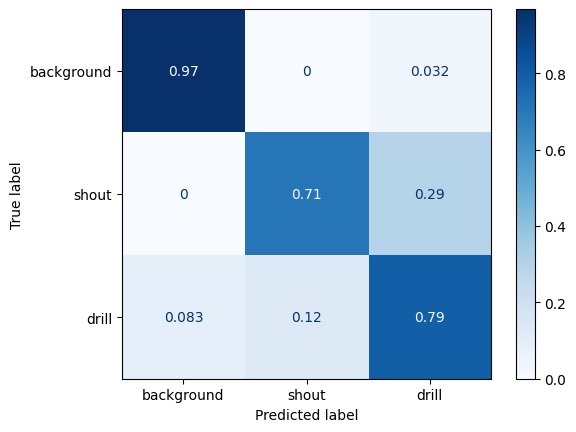

In [118]:
# Confusion Matrix Visualization displaying percentage of correct predictions
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=['background', 'shout', 'drill'],
    normalize='true',
    cmap=plt.cm.Blues
)



In [119]:
joblib.dump(pipeline, os.path.join(cwd, "model.joblib"))

['c:\\Users\\hoxia\\Documents\\Cloud\\NoiseWatch\\noise_prediction\\model.joblib']